In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
from datetime import datetime
from tqdm import tqdm

In [3]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 6 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[5*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()
    energydata = energydata.loc['2021-11-15':'2024-02-17']

    return energydata

In [4]:
df = get_energy_data()

100%|█████████████████████████████████████████| 224/224 [00:48<00:00,  4.60it/s]


In [5]:
df

,Netzlast_Gesamt
date_time,
2021-11-15 00:00:00,45773.50
2021-11-15 01:00:00,44447.50
2021-11-15 02:00:00,44038.50
2021-11-15 03:00:00,44291.75
2021-11-15 04:00:00,46944.50
...,...
2024-02-17 19:00:00,53936.25
2024-02-17 20:00:00,50303.00
2024-02-17 21:00:00,48103.25


In [6]:
#Rename column

In [7]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

In [8]:
# Rescale Netzlast to Gigawatt hours
df['gesamt'] = df['gesamt'] / 1000
#Check dtypes and if columns contain and missing values
df.dtypes

gesamt    float64
dtype: object

In [9]:
#Define weekday column

In [10]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
df

,gesamt,weekday
date_time,,
2021-11-15 00:00:00,45.77350,0
2021-11-15 01:00:00,44.44750,0
2021-11-15 02:00:00,44.03850,0
2021-11-15 03:00:00,44.29175,0
2021-11-15 04:00:00,46.94450,0
...,...,...
2024-02-17 19:00:00,53.93625,5
2024-02-17 20:00:00,50.30300,5
2024-02-17 21:00:00,48.10325,5


In [11]:
sub_train_df = df.loc[:'2023-11-15']
sub_train_df

,gesamt,weekday
date_time,,
2021-11-15 00:00:00,45.77350,0
2021-11-15 01:00:00,44.44750,0
2021-11-15 02:00:00,44.03850,0
2021-11-15 03:00:00,44.29175,0
2021-11-15 04:00:00,46.94450,0
...,...,...
2023-11-15 19:00:00,65.46025,2
2023-11-15 20:00:00,62.23250,2
2023-11-15 21:00:00,59.06100,2


In [12]:
sub_train_df.isna().any()

gesamt     False
weekday    False
dtype: bool

<Axes: xlabel='date_time'>

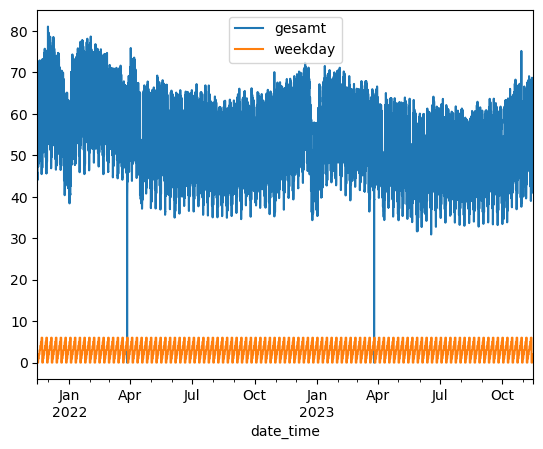

In [13]:
sub_train_df.plot()

In [14]:

sub_train_df=sub_train_df.drop(['2023-03-26 02:00:00', '2022-03-27 02:00:00'], axis=0)


<Axes: xlabel='date_time'>

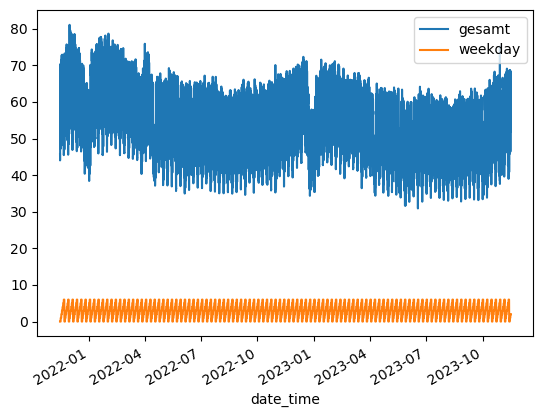

In [15]:
sub_train_df.plot()

In [16]:
horizons_predict = [36, 40, 44, 60, 64, 68]
horizons_def = [60, 64, 68, 84, 88, 92]#[24 + 12*i for i in range(5)]

Adapt horzions so they actually fit

In [17]:
#horizons = [h+1 for h in horizons_def]
#horizons

In [18]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [19]:
LAST_IDX = -24
LAST_DATE = sub_train_df.iloc[LAST_IDX].name

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [20]:
LAST_DATE

Timestamp('2023-11-15 00:00:00')

In [21]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons_def]
horizon_date

[Timestamp('2023-11-17 12:00:00'),
 Timestamp('2023-11-17 16:00:00'),
 Timestamp('2023-11-17 20:00:00'),
 Timestamp('2023-11-18 12:00:00'),
 Timestamp('2023-11-18 16:00:00'),
 Timestamp('2023-11-18 20:00:00')]

quantile levels

In [22]:
tau = [.025, .25, .5, .75, .975]

In [23]:
#rows correspond to horizon, columns to quantile level


In [24]:
subset_ts_train = []

for d in horizon_date:
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = sub_train_df.iloc[:LAST_IDX]
    
    # Filter dataframe based on weekday and hour
    cond = (df_tmp['weekday'] == weekday) & (df_tmp.index.hour == hour)
    filtered_data = df_tmp[cond]['gesamt']
    
    # Assign filtered data to pred_baseline
    subset_ts_train.append(filtered_data)

In [25]:
subset_ts_train

[date_time
 2021-11-19 12:00:00    71.74825
 2021-11-26 12:00:00    74.09450
 2021-12-03 12:00:00    77.65800
 2021-12-10 12:00:00    73.56475
 2021-12-17 12:00:00    70.77025
                          ...   
 2023-10-13 12:00:00    63.27950
 2023-10-20 12:00:00    66.69050
 2023-10-27 12:00:00    65.01350
 2023-11-03 12:00:00    63.56875
 2023-11-10 12:00:00    67.11725
 Name: gesamt, Length: 104, dtype: float64,
 date_time
 2021-11-19 16:00:00    68.17300
 2021-11-26 16:00:00    72.05600
 2021-12-03 16:00:00    76.46825
 2021-12-10 16:00:00    72.00400
 2021-12-17 16:00:00    68.72950
                          ...   
 2023-10-13 16:00:00    58.79025
 2023-10-20 16:00:00    60.27850
 2023-10-27 16:00:00    59.38925
 2023-11-03 16:00:00    60.92150
 2023-11-10 16:00:00    63.48250
 Name: gesamt, Length: 104, dtype: float64,
 date_time
 2021-11-19 20:00:00    62.78950
 2021-11-26 20:00:00    67.39475
 2021-12-03 20:00:00    71.07625
 2021-12-10 20:00:00    65.66425
 2021-12-17 20:00:00 

In [26]:
ts_Fri12_train = subset_ts_train[0]
ts_Fri16_train = subset_ts_train[1]
ts_Fri20_train = subset_ts_train[2]
ts_Sat12_train = subset_ts_train[3]
ts_Sat16_train = subset_ts_train[4]
ts_Sat20_train = subset_ts_train[5]

In [27]:
ts_Fri12_train

date_time
2021-11-19 12:00:00    71.74825
2021-11-26 12:00:00    74.09450
2021-12-03 12:00:00    77.65800
2021-12-10 12:00:00    73.56475
2021-12-17 12:00:00    70.77025
                         ...   
2023-10-13 12:00:00    63.27950
2023-10-20 12:00:00    66.69050
2023-10-27 12:00:00    65.01350
2023-11-03 12:00:00    63.56875
2023-11-10 12:00:00    67.11725
Name: gesamt, Length: 104, dtype: float64

In [28]:
ts_Fri12_train_df = pd.DataFrame(ts_Fri12_train)
ts_Fri12_train_df.columns = ['Friday 12:00']
ts_Fri12_train.shape

(104,)

In [29]:
ts_Fri12_train_df

,Friday 12:00
date_time,
2021-11-19 12:00:00,71.74825
2021-11-26 12:00:00,74.09450
2021-12-03 12:00:00,77.65800
2021-12-10 12:00:00,73.56475
2021-12-17 12:00:00,70.77025
...,...
2023-10-13 12:00:00,63.27950
2023-10-20 12:00:00,66.69050
2023-10-27 12:00:00,65.01350


In [30]:
ts_Fri16_train_df = pd.DataFrame(ts_Fri16_train)
ts_Fri16_train_df.columns = ['Friday 16:00']

In [31]:
ts_Fri16_train_df

,Friday 16:00
date_time,
2021-11-19 16:00:00,68.17300
2021-11-26 16:00:00,72.05600
2021-12-03 16:00:00,76.46825
2021-12-10 16:00:00,72.00400
2021-12-17 16:00:00,68.72950
...,...
2023-10-13 16:00:00,58.79025
2023-10-20 16:00:00,60.27850
2023-10-27 16:00:00,59.38925


In [32]:
ts_Fri20_train_df = pd.DataFrame(ts_Fri20_train)
ts_Fri20_train_df.columns = ['Friday 20:00']

In [33]:
ts_Sat12_train_df = pd.DataFrame(ts_Sat12_train)
ts_Sat12_train_df.columns = ['Saturday 12:00']


In [34]:
ts_Sat16_train_df = pd.DataFrame(ts_Sat16_train)
ts_Sat16_train_df.columns = ['Saturday 16:00']


In [35]:
ts_Sat20_train_df = pd.DataFrame(ts_Sat20_train)
ts_Sat20_train_df.columns = ['Saturday 20:00']


In [36]:
from statsmodels.tsa.seasonal import STL

In [37]:
plt.rc("figure", figsize=(15, 11))
plt.rc("font", size=12)

In [38]:
dec_Fri12 = STL(ts_Fri12_train_df['Friday 12:00'], seasonal=51)
res_dec_Fri12 = dec_Fri12.fit()


In [39]:
dec_Fri16 = STL(ts_Fri16_train_df['Friday 16:00'], seasonal=51)
res_dec_Fri16 = dec_Fri16.fit()


In [40]:
dec_Fri20 = STL(ts_Fri20_train_df['Friday 20:00'], seasonal=51)
res_dec_Fri20 = dec_Fri20.fit()


In [41]:
dec_Sat12 = STL(ts_Sat12_train_df['Saturday 12:00'], seasonal=51)
res_dec_Sat12 = dec_Sat12.fit()


In [42]:
dec_Sat16 = STL(ts_Sat16_train_df['Saturday 16:00'], seasonal=51)
res_dec_Sat16 = dec_Sat16.fit()


In [43]:
dec_Sat20 = STL(ts_Sat20_train_df['Saturday 20:00'], seasonal=51)
res_dec_Sat20 = dec_Sat20.fit()


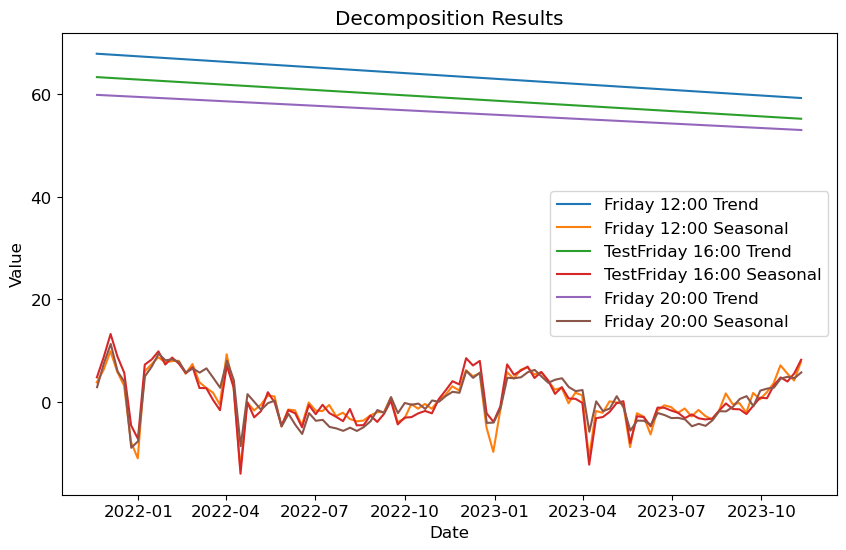

In [44]:
plt.figure(figsize=(10, 6))

# Plot the decomposition results for Friday three point hours
plt.plot(res_dec_Fri12.trend, label='Friday 12:00 Trend')
plt.plot(res_dec_Fri12.seasonal, label='Friday 12:00 Seasonal')


plt.plot(res_dec_Fri16.trend, label='TestFriday 16:00 Trend')
plt.plot(res_dec_Fri16.seasonal, label='TestFriday 16:00 Seasonal')


plt.plot(res_dec_Fri20.trend, label='Friday 20:00 Trend')
plt.plot(res_dec_Fri20.seasonal, label='Friday 20:00 Seasonal')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Decomposition Results')
plt.legend()

# Show the plot
plt.show()

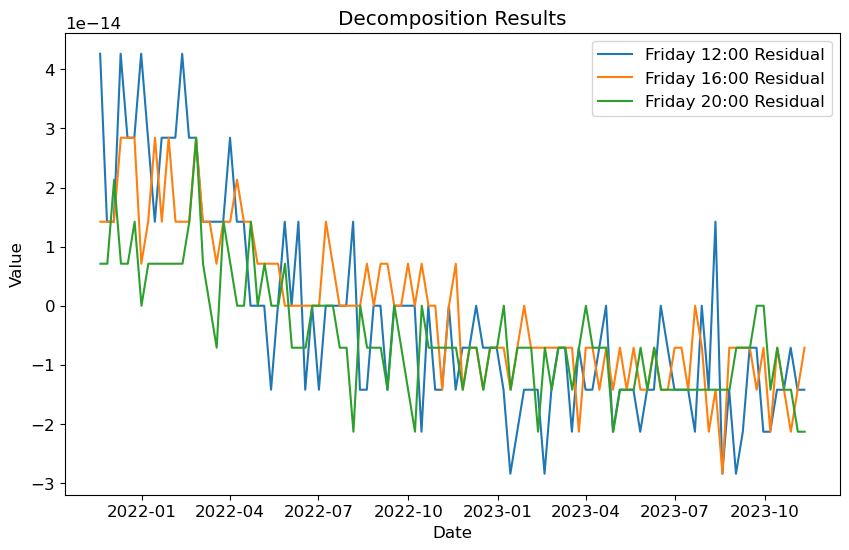

In [45]:
plt.figure(figsize=(10, 6))

# Plot the risidual after decomposition 
plt.plot(res_dec_Fri12.resid, label='Friday 12:00 Residual')


plt.plot(res_dec_Fri16.resid, label='Friday 16:00 Residual')


plt.plot(res_dec_Fri20.resid, label='Friday 20:00 Residual')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Decomposition Results')
plt.legend()

# Show the plot
plt.show()

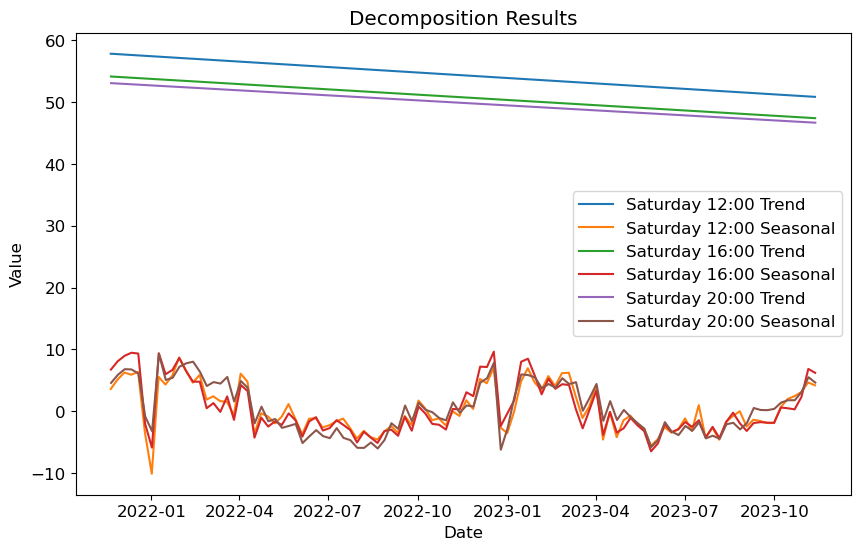

In [46]:
plt.figure(figsize=(10, 6))

# Plot the decomposition results for Saturday three point hours
plt.plot(res_dec_Sat12.trend, label='Saturday 12:00 Trend')
plt.plot(res_dec_Sat12.seasonal, label='Saturday 12:00 Seasonal')


plt.plot(res_dec_Sat16.trend, label='Saturday 16:00 Trend')
plt.plot(res_dec_Sat16.seasonal, label='Saturday 16:00 Seasonal')


plt.plot(res_dec_Sat20.trend, label='Saturday 20:00 Trend')
plt.plot(res_dec_Sat20.seasonal, label='Saturday 20:00 Seasonal')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Decomposition Results')
plt.legend()

# Show the plot
plt.show()

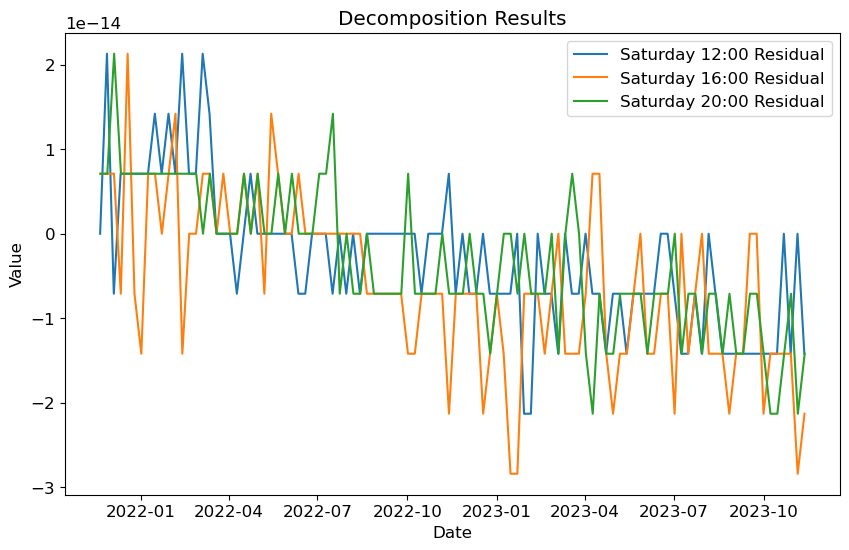

In [47]:
plt.figure(figsize=(10, 6))

# Plot the risidual after decomposition 
plt.plot(res_dec_Sat12.resid, label='Saturday 12:00 Residual')


plt.plot(res_dec_Sat16.resid, label='Saturday 16:00 Residual')


plt.plot(res_dec_Sat20.resid, label='Saturday 20:00 Residual')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Decomposition Results')
plt.legend()

# Show the plot
plt.show()

In [48]:
#Prediction 

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

In [50]:
ts_Fri12_train_df['Friday 12:00']
#ts_Fri16_train_df['Friday 16:00']
#ts_Fri20_train_df['Friday 20:00']
#ts_Sat12_train_df['Saturday 12:00']
#ts_Sat16_train_df['Saturday 16:00']
#ts_Sat20_train_df['Saturday 20:00']

date_time
2021-11-19 12:00:00    71.74825
2021-11-26 12:00:00    74.09450
2021-12-03 12:00:00    77.65800
2021-12-10 12:00:00    73.56475
2021-12-17 12:00:00    70.77025
                         ...   
2023-10-13 12:00:00    63.27950
2023-10-20 12:00:00    66.69050
2023-10-27 12:00:00    65.01350
2023-11-03 12:00:00    63.56875
2023-11-10 12:00:00    67.11725
Name: Friday 12:00, Length: 104, dtype: float64

In [51]:
Modul_Fri12 = STLForecast(ts_Fri12_train_df['Friday 12:00'], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))

In [52]:
fit_Fri12 = Modul_Fri12.fit()

/Applications/Anaconda3/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Applications/Anaconda3/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Applications/Anaconda3/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Applications/Anaconda3/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
resi_Fri12 = res_dec_Fri12.resid

In [54]:
fc_Fri12 = fit_Fri12.forecast(14)

In [55]:
fc_Fri12 = fc_Fri12.drop(['2023-12-29 12:00:00', '2024-01-05 12:00:00'])

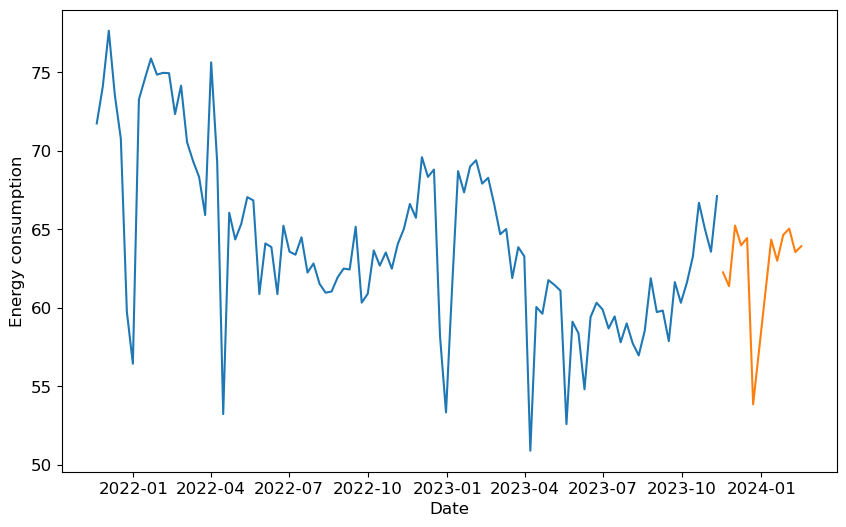

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(ts_Fri12_train_df['Friday 12:00'])
plt.plot(fc_Fri12)
plt.xlabel('Date')
plt.ylabel('Energy consumption')
plt.show()

In [57]:
resi_Fri12

date_time
2021-11-19 12:00:00    4.263256e-14
2021-11-26 12:00:00    1.421085e-14
2021-12-03 12:00:00    1.421085e-14
2021-12-10 12:00:00    4.263256e-14
2021-12-17 12:00:00    2.842171e-14
                           ...     
2023-10-13 12:00:00   -1.421085e-14
2023-10-20 12:00:00   -1.421085e-14
2023-10-27 12:00:00   -7.105427e-15
2023-11-03 12:00:00   -1.421085e-14
2023-11-10 12:00:00   -1.421085e-14
Name: resid, Length: 104, dtype: float64

In [58]:
quantiles = [.025, .25, .5, .75, .975]

In [59]:
quantiles = [.025, .25, .5, .75, .975]
empirical_quantiles = np.quantile(resi_Fri12, q=quantiles)

Compute quantile predictions on each day for desired quantile levels
quantile_predictions = {}
for tau, empirical_quantile in zip(quantiles, empirical_quantiles):
    quantile_prediction = fc_Fri12 + empirical_quantile
    quantile_predictions[tau] = quantile_prediction

SyntaxError: invalid syntax (1338914036.py, line 4)

In [ ]:
df_quantile_predictions = pd.DataFrame.from_dict(quantile_predictions, orient='index')

# Reset index to make quantiles a column
df_quantile_predictions.reset_index(inplace=True)
df_quantile_predictions.rename(columns={'index': 'quantile'}, inplace=True)

# Melt DataFrame to have quantiles as rows
df_quantile_predictions_melted = df_quantile_predictions.melt(id_vars='quantile', var_name='datetime', value_name='prediction')

# Convert  column to datetime
df_quantile_predictions_melted['datetime'] = pd.to_datetime(df_quantile_predictions_melted['datetime'])

df_quantile_predictions_melted

In [ ]:
df_quantile_predictions_Fri12 = df_quantile_predictions_melted.pivot_table(index='quantile', columns='datetime', values='prediction')

In [ ]:
df_quantile_predictions_Fri12

In [ ]:
subset_ts_test = []

for d in horizon_date:
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.loc['2023-11-15':]
    
    # Filter dataframe based on weekday and hour
    cond = (df_tmp['weekday'] == weekday) & (df_tmp.index.hour == hour)
    filtered_data = df_tmp[cond]['gesamt']
    
    # Assign filtered data to pred_baseline
    subset_ts_test.append(filtered_data)

In [ ]:
ts_Fri12_test = subset_ts_test[0]
ts_Fri16_test = subset_ts_test[1]
ts_Fri20_test = subset_ts_test[2]
ts_Sat12_test = subset_ts_test[3]
ts_Sat16_test= subset_ts_test[4]
ts_Sat20_test = subset_ts_test[5]

In [ ]:
ts_Fri12_test_df = pd.DataFrame(ts_Fri12_test)
ts_Fri16_test_df = pd.DataFrame(ts_Fri16_test)
ts_Fri20_test_df = pd.DataFrame(ts_Fri20_test)

In [ ]:
ts_Fri12_test_df=ts_Fri12_test_df.drop(['2023-12-29 12:00:00', '2024-01-05 12:00:00'])

In [ ]:
#with this very small residual and the quantile fo the residual, use sharpness evaluation and because the quantile after rounding almost the same
#it can be taken as the point evaluation. 
first_quantile_predictions = df_quantile_predictions_Fri12.iloc[0]


values_ts_Fri12_test = ts_Fri12_test_df.iloc[:, 0]
first_quantile_predictions.index = values_ts_Fri12_test.index

# Compare the values
error_Fri12 = []
error_Fri12 = values_ts_Fri12_test-first_quantile_predictions


In [ ]:
error_Fri12 